## Random Forest Baseline for Anomaly Detection for Curiosity Rover

This notebook contains a Random Forest-based approach I developed to detect anomalies in spacecraft telemetry data. The goal is to use supervised learning on sliding windows of time series data to classify whether each segment is normal or anomalous.

The dataset comes from the paper by Hundman et al. (2018), which introduced the **SMAP** and **MSL** spacecraft telemetry datasets. I use the labeled anomalies from the **MSL** subset to train and evaluate my model. All credit for the data goes to the original authors:

> Hundman, Kyle, et al. “Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding.” Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 19 July 2018, arxiv.org/pdf/1802.04431.pdf, https://doi.org/10.1145/3219819.3219845.




In [ ]:
import os
os.getcwd()

'/content'

Mounted at /content/drive
 Extracting telemetry data...
 Extracting labels from CSV
Flattening 'data' folder into /content/data...
 Data preparation complete.
   • Telemetry files → /content/data
   • Labels CSV      → /content/labeled_anomalies.csv
 Found 20 channels with anomalies.

▶️ Channel M-1 – intervals: 1
   • Windows: 2110, Anomalies: 1099 (52.09%)
   • Training Random Forest...
Best RF params: {'class_weight': {np.int64(0): np.float64(1.0430790960451977), np.int64(1): np.float64(0.9603381014304291)}, 'max_depth': np.int64(15), 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
Best validation F1: 0.9864
   • Optimal threshold = 0.5111
              precision    recall  f1-score   support

           0     0.9934    0.9934    0.9934       152
           1     0.9939    0.9939    0.9939       165

    accuracy                         0.9937       317
   macro avg     0.9937    0.9937    0.9937       317
weighted avg     0.9937    0.9937    0.9937       317


▶

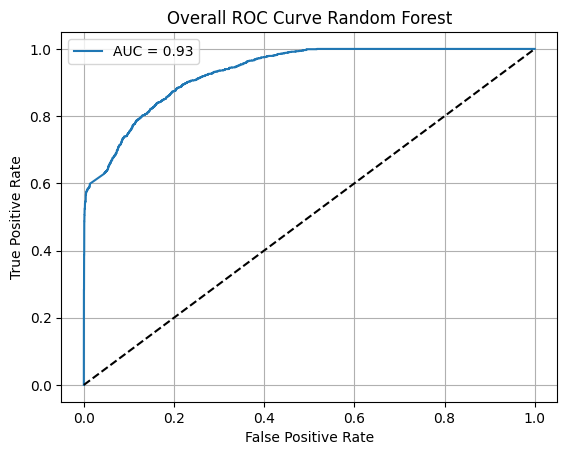

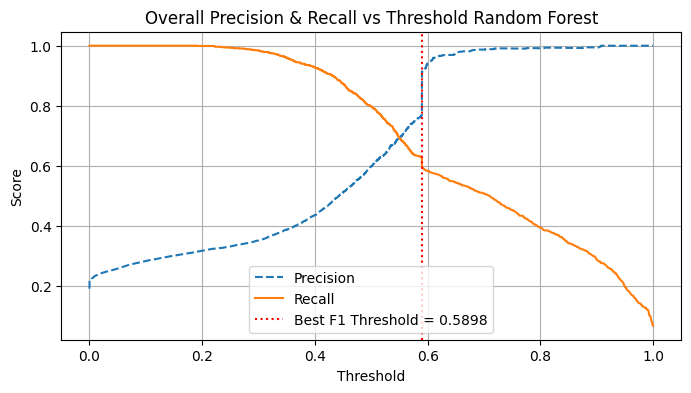

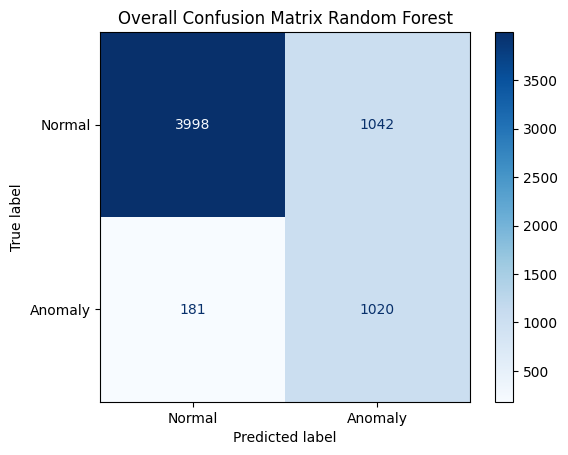

In [ ]:
# Random Forest as my baseline model
# Merve Şafak u314441
from google.colab import drive
import os, zipfile, shutil

# Mount Google Drive and set working paths
# I keep my dataset zipped in my Drive, so I unpack it here manually.
# These contain the telemetry .npy files and anomaly label CSV


drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/Colab Notebooks'

os.makedirs('/content/data', exist_ok=True)

data_zip = os.path.join(drive_path, 'data.zip')
# I keep my dataset zipped in my Drive, so I unpack it here manually.

if os.path.isfile(data_zip):
    print(" Extracting telemetry data...")
    with zipfile.ZipFile(data_zip, 'r') as archive:
        archive.extractall('/content/data')

labels_zip = os.path.join(drive_path, 'labeled_anomalies.csv.zip')
if os.path.isfile(labels_zip):
    print(" Extracting labels from CSV")
    with zipfile.ZipFile(labels_zip, 'r') as archive:
        archive.extractall('/content')
# When I unzip the data, it ends up under /content/data/data because the folder inside the ZIP is also named 'data'.
# This creates a nested directory, which I don't need.
# So I move all the .npy files up one level to /content/data to simplify file loading later on.
# After that, I delete the extra subfolder to clean up the structure.
src_folder = '/content/data/data'
if os.path.isdir(src_folder):
    print("Flattening 'data' folder into /content/data...")
    for fname in os.listdir(src_folder):
        src_file = os.path.join(src_folder, fname)
        dst_file = os.path.join('/content/data', fname)
        if not os.path.exists(dst_file):
            shutil.move(src_file, dst_file)
    shutil.rmtree(src_folder, ignore_errors=True)


print(" Data preparation complete.")
print("   • Telemetry files → /content/data")
print("   • Labels CSV      → /content/labeled_anomalies.csv")

# Standard imports for data handling and modeling
import ast, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Random Forest and evaluation tools from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint

# I'm setting fixed random seeds so that things like train/test splits and model training
# produce the same results every time I run the code. This is important for debugging and for
# comparing models fairly without randomness affecting the outcome.

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# This function loads the CSV file that contains anomaly labels for each channel.
# I filter it to only use rows for the MSL spacecraft, since that's what I'm analyzing here.
# Then for each labeled channel, I check if the .npy telemetry file exists,
# and only keep the channels where both the file and usable anomaly intervals are present.
def load_msl_channels_with_anomalies(csv_path, data_dir):
    """Loading Msl Channels"""
    df = pd.read_csv(csv_path)
    df = df[df.spacecraft == 'MSL'].reset_index(drop=True)
    channels = []
    for _, row in df.iterrows():
        chan = row.chan_id
        intervals = ast.literal_eval(row.anomaly_sequences)
        npy_path = os.path.join(data_dir, f"{chan}.npy")
        if not os.path.isfile(npy_path):
            continue
        ts = np.load(npy_path)
        if any(start < ts.shape[0] for (start, _) in intervals):
            channels.append({'chan_id': chan, 'path': npy_path, 'intervals': intervals})
    return channels

# This function takes a time series and slices it into overlapping windows of fixed size.
# Each window is given a label: 1 if it overlaps with any anomaly interval, 0 otherwise.
# This turns the time series into a supervised dataset I can use to train a classifier.
def create_windows(ts, intervals, window_size):
    """Create windowss"""
    n = ts.shape[0]
    feats = ts.shape[1] if ts.ndim > 1 else 1
    X, y = [], []
    for start in range(n - window_size + 1):
        window = ts[start:start + window_size]
        if ts.ndim == 1:
            window = window.reshape(window_size, 1)
        label = int(any(start < end and start + window_size > begin
                      for (begin, end) in intervals))
        X.append(window)
        y.append(label)
    if not X:
        return np.empty((0, window_size, feats)), np.empty((0,), int)
    return np.stack(X), np.array(y, dtype=int)

# Plotting function for visualizing training/validation loss — mostly used for deep learning models,
# but I kept it in case I want to compare this Random Forest with a future neural network baseline.
def plot_loss_curve(history, channel, tag):
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{channel} • {tag} Loss Random Forest")
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    os.makedirs(f"plots/{channel}", exist_ok=True)
    plt.savefig(f"plots/{channel}/loss_rf{tag}.png", dpi=300)
    plt.close()

# Standard ROC curve to show how well the model separates classes at different thresholds.
# The closer the curve is to the top-left corner, the better the model.
def plot_roc_curve(y_true, y_prob, channel, tag):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{channel} • {tag} ROC Random Forest")
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(); plt.grid(True)
    os.makedirs(f"plots/{channel}", exist_ok=True)
    plt.savefig(f"plots/{channel}/roc_rf{tag}.png", dpi=300)
    plt.close()
# Confusion matrix makes it easier to understand how the model is performing — for example,
# whether it's predicting too many false positives or missing true anomalies.
def plot_conf_matrix(y_true, y_pred, channel, tag):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Anomaly'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{channel} • {tag} Confusion Matrix Random Forest")
    os.makedirs(f"plots/{channel}", exist_ok=True)
    plt.savefig(f"plots/{channel}/conf_matrix_rf{tag}.png", dpi=300)
    plt.close()


# This one plots precision and recall scores across all thresholds.
# I use this to find the threshold that gives the best balance (F1 score) for each channel.
def plot_precision_recall_vs_threshold(y_true, y_prob, channel):
    p, r, thresholds = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(8,4))
    plt.plot(thresholds, p[:-1], '--', label='Precision')
    plt.plot(thresholds, r[:-1], '-', label='Recall')
    plt.xlabel('Threshold'); plt.legend()
    plt.title(f"{channel} • Precision/Recall vs Threshold Random Forest")
    os.makedirs(f"plots/{channel}", exist_ok=True)
    plt.savefig(f"plots/{channel}/precision_recall_threshold_rf.png", dpi=300)
    plt.close()


# This function trains a Random Forest on the labeled sliding windows.
# Since RF only accepts 2D input, I flatten each 2D window into a 1D vector.
# So instead of (samples, window_size, features), the input becomes (samples, window_size × features).
def train_random_forest(X_train, y_train, X_val, y_val):
    """Train and tune my Random Forest classifier"""
    n_samples, window_size, n_features = X_train.shape
    X_train_flat = X_train.reshape(n_samples, -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Ref: https://stackoverflow.com/questions/72935266/detecting-anomalies-among-several-thousand-users
#https://stackoverflow.com/questions/60442051/balancing-data-in-python-by-using-smote-library/60442298#60442298
# I was stuck on how to balance classes properly — this StackOverflow answer helped me realize I could compute class weights manually
# (basically tells the model to take anomalies more seriously during training)

# Since anomalies are rare, the model might ignore them without help.
# So I use class weights here to balance things out a bit.

    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight = dict(zip(classes, weights))

# Here I'm defining a range of hyperparameters for the Random Forest to try.
# I use RandomizedSearchCV to explore this space efficiently with 20 trials.
# It uses cross-validation to estimate which set of parameters performs best.

    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': [None] + list(np.arange(5, 30, 5)),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'class_weight': [class_weight]
    }
    # Ref: https://stackoverflow.com/a/44542084/1169798
    # Now training + tuning the Random Forest using randomized search
    rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    search = RandomizedSearchCV(
        rf, param_dist, n_iter=20, scoring='f1',
        cv=3, n_jobs=-1, random_state=SEED
    )
    search.fit(X_train_flat, y_train)

    print(f"Best RF params: {search.best_params_}")
    print(f"Best validation F1: {search.best_score_:.4f}")

    return search.best_estimator_


# This is the main function that runs everything from start to finish.
# It loads the labeled data, generates sliding windows, trains the model, evaluates it,
# and saves both the metrics and the predictions for later analysis.

def main():
    csv_path = '/content/labeled_anomalies.csv'
    data_dir = '/content/data'
    window_size = 100  # Same as your CNN window size

    # Load all MSL channels that have anomaly labels
    channels = load_msl_channels_with_anomalies(csv_path, data_dir)
    print(f" Found {len(channels)} channels with anomalies.")

    # Containers for overall metrics
    all_y_true, all_y_pred, all_y_prob = [], [], []
    precisions, recalls, f1s, fps, fns = [], [], [], [], []

    for ch in channels:
        chan_id, path, intervals = ch['chan_id'], ch['path'], ch['intervals']
        ts = np.load(path)
        print(f"\n▶ Channel {chan_id} – intervals: {len(intervals)}")

# I chose a window size of 100 after some trial and error — it seemed to capture enough context
# without being too large to dilute the anomaly signal.
# This loop goes over each telemetry channel with labels.
# For each channel, I generate the dataset, train a model, evaluate it, and store the results.

        X, y = create_windows(ts, intervals, window_size)
        print(f"   • Windows: {X.shape[0]}, Anomalies: {y.sum()} ({y.mean()*100:.2f}%)")
        if X.size == 0:
            continue

# I split the dataset the same way as in my CNN models:
# 70% for training, and 15% each for validation and test.
# Stratify makes sure the anomaly/normal ratio stays consistent across all splits.
# I use the validation set for hyperparameter tuning (RandomizedSearchCV),
# and the test set is only used to evaluate the final model.


        X_train, X_tmp, y_train, y_tmp = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=SEED
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
        )

        # Train Random Forest
        print("   • Training Random Forest...")
        rf_model = train_random_forest(X_train, y_train, X_val, y_val)

        # Evaluate on test set
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        y_prob = rf_model.predict_proba(X_test_flat)[:, 1]

# Ref: https://stackoverflow.com/a/54031335/1169798
# After training the model, I predict on the test set and get a probability score for each window.
# Then I choose the threshold that gives the best F1 score (not just 0.5).
# This is important in imbalanced problems like anomaly detection.

        p, r, thresh = precision_recall_curve(y_test, y_prob)
        f1_scores = 2*p*r/(p+r+1e-6)
        best_idx = np.argmax(f1_scores)
        best_thr = thresh[best_idx]
        y_pred = (y_prob > best_thr).astype(int)
        print(f"   • Optimal threshold = {best_thr:.4f}")
        print(classification_report(y_test, y_pred, digits=4))


# I evaluate performance using precision, recall, F1 score, and confusion matrix.
# These help me understand both overall accuracy and how well anomalies are being detected.

        plot_precision_recall_vs_threshold(y_test, y_prob, chan_id)
        plot_roc_curve(y_test, y_prob, chan_id, 'rf')
        plot_conf_matrix(y_test, y_pred, chan_id, 'rf')



        os.makedirs('outputs', exist_ok=True)
        np.savez_compressed(f"outputs/{chan_id}_rf_pred.npz",
                           y_true=y_test, y_pred=y_pred, y_prob=y_prob)


        cm = confusion_matrix(y_test, y_pred).ravel()
        tp, fp_, tn, fn_ = cm[3], cm[1], cm[0], cm[2]
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        fps.append(int(fp_)); fns.append(int(fn_))
        all_y_true.extend(y_test); all_y_pred.extend(y_pred); all_y_prob.extend(y_prob)



# Once all channels are done, I calculate average performance across all of them,
# and also compute metrics for all predictions combined to see overall model quality.

    overall_prec = precision_score(all_y_true, all_y_pred)
    overall_rec = recall_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred)
    fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
    overall_auc = auc(fpr, tpr)

    print("\n Random Forest Overall Performance:")
    print(f"  • Precision: {overall_prec:.4f}")
    print(f"  • Recall   : {overall_rec:.4f}")
    print(f"  • F1 Score : {overall_f1:.4f}")
    print(f"  • ROC AUC  : {overall_auc:.4f}")

    # Save overall summary
    summary = {
        'precision': overall_prec, 'recall': overall_rec,
        'f1_score': overall_f1, 'roc_auc': overall_auc
    }
    with open('outputs/rf_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    # For overall plots
    os.makedirs("plots/overall", exist_ok=True)

    # ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {overall_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Overall ROC Curve Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig("plots/overall/roc_curve_rf.png", dpi=300)
    plt.close()

    # PR vs threshold
    precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precision[:-1], '--', label='Precision')
    plt.plot(thresholds, recall[:-1], '-', label='Recall')
    plt.axvline(best_threshold, color='r', linestyle=':', label=f'Best F1 Threshold = {best_threshold:.4f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Overall Precision & Recall vs Threshold Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig("plots/overall/precision_recall_vs_threshold_rf.png", dpi=300)
    plt.close()

    # Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Overall Confusion Matrix Random Forest")
    plt.show()
    plt.savefig("plots/overall/conf_matrix_rf.png", dpi=300)
    plt.close()


# I save the overall summary as a JSON file so it's easy to reuse in plots or reports.

    summary = {
        'precision': overall_prec, 'recall': overall_rec,
        'f1_score': overall_f1, 'roc_auc': overall_auc
    }
    with open('outputs/rf_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

if __name__ == '__main__':
    main()